<a href="https://colab.research.google.com/github/Vizzuality/copernicus-climate-data/blob/master/prepare_eu_nuts_mask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data for the copernicus climate project

https://github.com/Vizzuality/copernicus-climate-data

`Edward P. Morris (vizzuality.)`

## Description
This notebook creates an dataset of geometries and properties, and dataset of mask arrays using the NUTS 2016 classification. NUTS (Nomenclature of Territorial Units for Statistics) is a European Union standard for referencing the subdivisions of countries (member states, candidate countries and EFTA countries). The datasets are exported as cloud optimised ZARR ready for use in further processing.

```
MIT License

Copyright (c) 2020 Vizzuality

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

# Setup

## Linux dependencies

In [2]:
!apt install -q -y libspatialindex-dev libproj-dev proj-data proj-bin libgeos-dev

Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
libspatialindex-dev is already the newest version (1.8.5-5).
proj-bin is already the newest version (4.9.3-2).
proj-data is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


## Python packages

In [0]:
# Fix for cartopy and shapely issues
#!pip install shapely cartopy --no-binary shapely --no-binary cartopy

In [3]:
!pip install -q geos cftime netcdf4 zarr xarray xclim gcsfs nc-time-axis rioxarray geopandas regionmask --upgrade #dask distributed 

     |████████████████████████████████| 368kB 2.8MB/s 
     |████████████████████████████████| 317kB 23.4MB/s 
     |████████████████████████████████| 4.1MB 55.7MB/s 
     |████████████████████████████████| 3.3MB 39.3MB/s 
     |████████████████████████████████| 655kB 52.2MB/s 
     |████████████████████████████████| 102kB 14.6MB/s 
     |████████████████████████████████| 3.7MB 46.0MB/s 
     |████████████████████████████████| 931kB 49.1MB/s 
     |████████████████████████████████| 122kB 47.3MB/s 
     |████████████████████████████████| 3.8MB 40.4MB/s 
     |████████████████████████████████| 10.4MB 33.0MB/s 
     |████████████████████████████████| 14.7MB 37.2MB/s 
     |████████████████████████████████| 174kB 54.2MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 194kB 59.6MB/s 
     |████████████████████████████████| 18.1MB 190kB/s 
     |████████████████████████████████| 8.9MB 49.2MB/s 
  Installing build dependencies ... done
  Getti

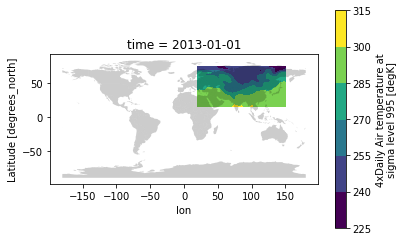

In [4]:
# Check plotting
# FIXME: cartopy, shapely cause Colab to crash!
%matplotlib inline
#import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres')).to_crs('EPSG:4326')
air = xr.tutorial.open_dataset('air_temperature').air
air['lon'] = air['lon'] - 180
#ax = plt.axes()

ax = world.plot(alpha=0.2, color='black')
air.isel(time=0).plot.contourf(ax=ax,zorder=-1);

#ax.set_global(); ax.coastlines();



## Authorisation

In [0]:
# For auth WITHOUT service account
#from google.colab import auth
#auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
#project_id = "skydipper-196010"
#!gcloud config set project {project_id}

In [0]:
# Copy GC credentials to home (place in your GDrive, and connect Drive)
!cp "/content/drive/My Drive/skydipper-196010-f842645fd0f3.json" "/root/.skydipper-196010-f842645fd0f3.json"

In [7]:
# Auth WITH service account
!gcloud auth activate-service-account \
  edward-morris@skydipper-196010.iam.gserviceaccount.com \
          --key-file=/root/.skydipper-196010-f842645fd0f3.json --project="skydipper-196010"


Activated service account credentials for: [edward-morris@skydipper-196010.iam.gserviceaccount.com]


In [8]:
# Test GC auth
!gsutil ls "gs://copernicus-climate"

gs://copernicus-climate/RH_ERA5.zip
gs://copernicus-climate/RH_ERA5_2.zip
gs://copernicus-climate/mrt_ERA5-HEAT.zip
gs://copernicus-climate/sp_ERA5.zip
gs://copernicus-climate/spain.zarr.zip
gs://copernicus-climate/t2m_ERA5.zip
gs://copernicus-climate/variables_futuro_CMIP5_AEMET.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_1.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_2.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_3.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_4.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_1.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_2.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_3.zip
gs://copernicus-climate/ws_ERA5.zip
gs://copernicus-climate/dataset/
gs://copernicus-climate/ref-nuts-2016-01m.zarr/
gs://copernicus-climate/spain.zarr/


In [0]:
# Clean up
!rm -r sample_data

## Dask

In [0]:
# FIXME: Old dask version in CoLab, update causes crashes!
#from distributed import Client

# Depending on your workstation specifications, you may need to adjust these values.
# On a single machine, n_workers=1 is usually better.
# n_workers=1, threads_per_worker=4, memory_limit="4GB"
#Client(processes=False, diagnostic_port=None)
#client


# Utils

## get_cached_remote_zarr

In [0]:
import gcsfs
import zarr
import xarray as xr
# Set display to HTML sytle (optional)
xr.set_options(display_style='html', display_width=80, warn_for_unclosed_files=True, keep_attrs=True)


def get_cached_remote_zarr(
    group,
    root,
    project_id = "skydipper-196010",
    token="/root/.skydipper-196010-f842645fd0f3.json"
    ):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  store = gc.get_mapper(root, check=False, create=False)
  # Check zarr is consolidated
  consolidated = gc.exists(f'{root}/.zmetadata')
  # Cache the zarr store
  #store = zarr.ZipStore(store, mode='r')
  cache = zarr.LRUStoreCache(store, max_size=None)
  # Return cached zarr group
  return xr.open_zarr(cache, group=group, consolidated=consolidated)

## write_to_local_zarr

In [0]:
import zarr
import xarray as xr
import os

def write_to_local_zarr(ds, group, root):
  
  # Write to zarr group
  ds.to_zarr(store=root, group=group, mode="w", consolidated=True)
  # consolidate metadata at root
  zarr.consolidate_metadata(root)
  c = os.path.exists(f"{root}/.zmetadata")
  print(f"{root} is consoldiated? {c}")
  with zarr.open(root, mode='r') as z:
    print(z.tree())
    


## write_to_remote_zarr

In [0]:
import gcsfs
import zarr
import xarray as xr
# Set display to HTML sytle (optional)
xr.set_options(display_style='html', display_width=80)

def write_to_remote_zarr(
    ds,
    group,
    root,
    project_id = "skydipper-196010",
    token="/root/.skydipper-196010-f842645fd0f3.json"
    ):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  store = gc.get_mapper(root, check=False, create=True)
  
  # Write to zarr group
  ds.to_zarr(store=store, group=group, mode="w", consolidated=True)
  # consolidate metadata at root
  zarr.consolidate_metadata(store)
  c = gc.exists(f"{root}/.zmetadata")
  print(f"{root} is consoldiated? {c}")
  with zarr.open(store, mode='r') as z:
    print(z.tree())



## mkdirs

In [0]:
from pathlib import Path

def mkdirs(dirs_list, exist_ok=True):
  """ Create nested directories
  """
  for p in dirs_list:
    Path(p).mkdir(parents=True, exist_ok=exist_ok)


## add_area

In [0]:
import numpy as np
import numpy.matlib
import xarray as xr
import rioxarray

def add_area(ds):
  """
  Add DataArrays of the area in km2 and area weight of each array cell

  """
  # get info
  lon = ds.lon.values
  lat = ds.lat.values
  xdim = len(lon)
  ydim = len(lat)
  lonmin = lon.min()
  latmin = lat.min()
  lonmax = lon.max()
  latmax = lat.max()
  xres = (lonmax - lonmin) / xdim
  yres = (latmax - latmin) / ydim 
  
  # create lats + yres
  lats = np.linspace(int(latmin), int(latmax) + yres, ydim + 1)
  
  # constants
  a = 6378137
  b = 6356752.3142

  # Degrees to radians
  lats = lats * np.pi/180

  # Intermediate vars
  e = np.sqrt(1-(b/a)**2)
  sinlats = np.sin(lats)
  zm = 1 - e * sinlats
  zp = 1 + e * sinlats

  # Distance between meridians
  q = yres/360
  # q = pix_width/360

  # Compute areas for each latitude in square km
  areas_to_equator = np.pi * b**2 * ((2*np.arctanh(e*sinlats) / (2*e) + sinlats / (zp*zm))) / 10**6
  areas_between_lats = np.diff(areas_to_equator)
  areas_cells = np.abs(areas_between_lats) * q
  areagrid = np.transpose(np.matlib.repmat(areas_cells, xdim, 1))
  
  # Sum total area
  #tot_area = np.sum(areagrid)

  # Add area in km2
  da = xr.DataArray(
      data=areagrid,
      name='area_km2',
      coords=[lat, lon],
      dims=['lat', 'lon'], 
      attrs=None, indexes=None, fastpath=False)
  # Add area_weight
  #ds['area_weight'] = ds['area_km2'] / tot_area
  
  return ds.assign({'area_km2': da.chunk({'lat':-1, 'lon':-1})})



## set_lat_lon_attrs

In [0]:
def set_lat_lon_attrs(ds):
  """ Set CF latitude and longitude attributes"""
  ds["lon"] = ds.lon.assign_attrs({
    'axis' : 'X',
     'long_name' : 'longitude',
      'standard_name' : 'longitude',
       'stored_direction' : 'increasing',
        'type' : 'double',
         'units' : 'degrees_east',
          'valid_max' : 360.0,
           'valid_min' : -180.0
           })
  ds["lat"] = ds.lat.assign_attrs({
    'axis' : 'Y',
     'long_name' : 'latitude',
      'standard_name' : 'latitude',
       'stored_direction' : 'increasing',
        'type' : 'double',
         'units' : 'degrees_north',
          'valid_max' : 90.0,
           'valid_min' : -90.0
           })
  return ds
  

## create_ds_mask

In [0]:
import regionmask
import xarray as xr
import rioxarray
import geopandas

def create_ds_mask(df, ds, id_prop, name_prop, name):
  # clip to bounding box of ds
  xmin = ds.lon.min().values.tolist()
  xmax = ds.lon.max().values.tolist()
  ymin = ds.lat.min().values.tolist()
  ymax = ds.lat.max().values.tolist()
  df = df.cx[xmin:xmax, ymin:ymax]
  # extract geoms, codes, names, and create code_ints
  id_ints = list(range(0,len(df)))
  id_names = list(df[name_prop])
  id_codes = list(df[id_prop])
  geoms = list(df.geometry.values[i] for i in range(0, len(df)))
  # create mask object
  m = regionmask.Regions(
    name = name,
    numbers = id_ints,
    names = id_names,
    abbrevs = id_codes,
    outlines = geoms)\
    .mask(ds)\
    .rename(name)
  # update da attributes
  m.attrs['id_ints'] = id_ints
  m.attrs['id_codes'] = id_codes  
  m.attrs['id_names'] = id_names
  m = set_lat_lon_attrs(m)
  return m
  

## create_bbox_mask

In [0]:
import regionmask
import xarray as xr
import rioxarray
import geopandas

def create_bbox_mask(df, xmin, ymin, xamx, ymax, xres, yres, id_prop, name_prop, name):
  # create base grid from bounding box
  ds = regionmask.core.utils.create_lon_lat_dataarray_from_bounds(
      *(xmin, xmax, xres),
      *(ymin, ymax, yres)
      )
  # clip df to bbox
  df = df.cx[xmin:xmax, ymin:ymax]
  # extract geoms, codes, names, and create code_ints
  id_ints = list(range(0,len(df)))
  id_names = list(df[name_prop])
  id_codes = list(df[id_prop])
  geoms = list(df.geometry.values[i] for i in range(0, len(df)))
  # create mask object
  m = regionmask.Regions(
    name = name,
    numbers = id_ints,
    names = id_names,
    abbrevs = id_codes,
    outlines = geoms)\
    .mask(ds)\
    .rename(name)
  # update da attributes
  m.attrs['id_ints'] = id_ints
  m.attrs['id_codes'] = id_codes  
  m.attrs['id_names'] = id_names
  m = set_lat_lon_attrs(m)
  return m
  

## round_bbox

In [0]:
import numpy as np
import decimal

def round_bbox(bbox, xres, yres):
  xmin = decimal.Decimal(bbox[0]).quantize(decimal.Decimal(str(xres)), rounding=decimal.ROUND_FLOOR)
  xmax = decimal.Decimal(bbox[2]).quantize(decimal.Decimal(str(xres)), rounding=decimal.ROUND_CEILING)
  ymin = decimal.Decimal(bbox[1]).quantize(decimal.Decimal(str(yres)), rounding=decimal.ROUND_FLOOR)
  ymax = decimal.Decimal(bbox[3]).quantize(decimal.Decimal(str(yres)), rounding=decimal.ROUND_CEILING)
  return [float(xmin), float(ymin), float(xmax), float(ymax)]

#bbox = tst.total_bounds
#print(bbox)
#round_bbox(bbox, xres = 0.1, yres = 0.1)  


## create_gdf_mask

In [0]:
import regionmask
import xarray as xr
import rioxarray
import geopandas

def create_gdf_mask(gdf, xres, yres, id_prop, name_prop, name):
  # get total bounds of gdf
  bbox = gdf.total_bounds
  # round
  bb = round_bbox(bbox, xres = xres, yres = yres)
  # create base grid from bounding box
  ds = regionmask.core.utils.create_lon_lat_dataarray_from_bounds(
      *(bb[0], bb[2], xres),
      *(bb[1], bb[3], yres)
      )
  # extract geoms, codes, names, and create code_ints
  id_ints = list(range(0,len(gdf)))
  id_names = list(gdf[name_prop])
  id_codes = list(gdf[id_prop])
  geoms = list(gdf.geometry.values[i] for i in range(0, len(gdf)))
  # create mask object
  m = regionmask.Regions(
    name = name,
    numbers = id_ints,
    names = id_names,
    abbrevs = id_codes,
    outlines = geoms)\
    .mask(ds)\
    .rename(name)
  # update da attributes
  m.attrs['id_ints'] = id_ints
  m.attrs['id_codes'] = id_codes  
  m.attrs['id_names'] = id_names
  m = set_lat_lon_attrs(m)
  return m
  

## create_nuts_mask

In [0]:
# FIXME update dataset attributes
def create_nuts_mask(df, ds, levels=[0,1,2,3]):
  das = [create_ds_mask(df.loc[(df['LEVL_CODE'] == l)], ds, 'NUTS_ID', 'NUTS_NAME', f"NUTS_{l}") for l in levels]
  out = xr.merge([da.to_dataset() for da in das])
  out = set_lat_lon_attrs(out)
  return out.rio.set_crs('EPSG:4326').rio.set_spatial_dims('lat', 'lon')

## get_gda_geoms

In [0]:
import geopandas as gpd
import shapely

def get_gda_geoms(group, select_by=None, root = "copernicus-climate/ref-nuts-2016-01m.zarr"):
  gda = get_cached_remote_zarr(group, root = root)
  # Select
  if select_by:
    gda = gda.sel(select_by, drop=True)
  df = gda.reset_coords().to_dataframe().dropna().reset_index()
  geoms = df.geometry
  # Return as geopandas object, converting geometry to shapley objects
  return gpd.GeoDataFrame(df, geometry=[shapely.wkb.loads(g, True) for g in geoms])


## area_wt_mean

In [0]:
import shapely


def area_wt_mean(ds, vars, id_prop, mask):
  da = (ds[vars] * ds.area_km2).groupby(ds[mask]).sum()
  area = ds.area_km2.groupby(ds[mask]).sum().rename("total_area")
  da = (da / area)\
  .rename( dict(zip(vars, [f"{var}_mean" for var in vars])))
  id_ints = da[mask].values.astype(numpy.int64) 
  id_codes = ds[mask].attrs['id_codes']
  id_codes = [id_codes[i] for i in id_ints]
  da = da.rename({mask:id_prop})
  da = da.assign_coords({id_prop:id_codes})
  return da.chunk({id_prop:-1})

# Process data

### Setup directory structure

In [0]:
import numpy as np
# Define area of interest and grid
bbox = [35, -10, 44, 5] # ymin, xmin, ymax, xmax
res = [0.1, 0.1]

# Define paths
ds_dir = "dataset"
gs_prefix ="gs://copernicus-climate"
dirs_list = [f"{ds_dir}/ref-nuts-2016-01m"]            

In [24]:
# Start with a clean structure
!rm -r {ds_dir}
!rm *.nc

rm: cannot remove 'dataset': No such file or directory
rm: cannot remove 'ref-nuts-2016-01m.zarr': No such file or directory
rm: cannot remove '*.nc': No such file or directory


In [0]:
# Make directory structure
mkdirs(dirs_list, exist_ok=True)

In [0]:
# Start with clean GCS ZARR
#!gsutil -m rm -r gs://copernicus-climate/ref-nuts-2016-01m.zarr

## Get NUTS 2016 classification from GISCO API

In [0]:
import requests
url = 'https://ec.europa.eu/eurostat/cache/GISCO/distribution/v2/nuts/download/ref-nuts-2016-01m.gdb.zip'

def download_url(url, save_path, chunk_size=512):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
download_url(url, 'ref-nuts-2016-01m.gdb.zip')



In [0]:
# Extract
import zipfile
with zipfile.ZipFile('ref-nuts-2016-01m.gdb.zip', 'r') as zip_ref:
    zip_ref.extractall(f"{ds_dir}/ref-nuts-2016-01m")

### Load geometries

In [0]:
import geopandas as gpd

# Load the geometries
p = f"{ds_dir}/ref-nuts-2016-01m/ref-nuts-2016-01m.gdb"
gdf = gpd.read_file(p).to_crs("EPSG:4326").set_index('NUTS_ID', drop=False)



## Create geo-dataset

In [29]:
import xarray as xr
import shapely

# FIXME: Look into whether this is better as a optimised stacked MultiIndex, i.e, {LEVL_CODE: 0, ISO3_CODE: {...}} 

# Set indexs
try:
  gdf = gdf.set_index(['LEVL_CODE', 'ISO3_CODE', 'NUTS_ID'], drop=True).dropna(how='all')
  gdf.sort_index(inplace=True)
  # Convert geoms to WKT binary hex 
  geoms = [shapely.wkb.dumps(g, hex=True) for g in gdf.geometry]
  gdf['geometry'] = geoms
except:
  pass
# Create ds, making 1 chunk per ISO3_CODE
nuts_gda = xr.Dataset.from_dataframe(gdf).chunk({'ISO3_CODE':1})
nuts_gda

,Array,Chunk
Bytes,2.39 MB,64.51 kB
Shape,"(4, 37, 2016)","(4, 1, 2016)"
Count,38 Tasks,37 Chunks
Type,object,numpy.ndarray
,Array,Chunk
Bytes,2.39 MB,64.51 kB
Shape,"(4, 37, 2016)","(4, 1, 2016)"
Count,38 Tasks,37 Chunks
Type,object,numpy.ndarray
,Array,Chunk


In [0]:
#n.sel(LEVL_CODE=2, ISO3_CODE='ESP', drop=True).to_dataframe().dropna()

### Export to remote ZARR

In [31]:
import zarr
import xarray as xr

# FIXME: how to remove serialisation error?
# Create remote ZARR
write_to_remote_zarr(nuts_gda, 'geo-data-array', root = "copernicus-climate/ref-nuts-2016-01m.zarr")

/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:188: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  SerializationWarning,
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:188: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  SerializationWarning,
/usr/local/lib/python3.6/dist-packages/xarray/conventions.py:188: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely store

copernicus-climate/ref-nuts-2016-01m.zarr is consoldiated? True
/
 ├── geo-data-array
 │   ├── CAPT (4, 37, 2016) object
 │   ├── CC_STAT (4, 37, 2016) object
 │   ├── CNTR_CODE (4, 37, 2016) object
 │   ├── EFTA_STAT (4, 37, 2016) object
 │   ├── EU_STAT (4, 37, 2016) object
 │   ├── ISO3_CODE (37,) object
 │   ├── LEVL_CODE (4,) int64
 │   ├── NAME_ASCI (4, 37, 2016) object
 │   ├── NAME_ENGL (4, 37, 2016) object
 │   ├── NAME_FREN (4, 37, 2016) object
 │   ├── NAME_GERM (4, 37, 2016) object
 │   ├── NAME_HTML (4, 37, 2016) object
 │   ├── NAME_LATN (4, 37, 2016) object
 │   ├── NUTS_ID (2016,) object
 │   ├── NUTS_NAME (4, 37, 2016) object
 │   ├── SVRG_UN (4, 37, 2016) object
 │   ├── Shape_Area (4, 37, 2016) float64
 │   ├── Shape_Length (4, 37, 2016) float64
 │   └── geometry (4, 37, 2016) object
 └── mask-array-0-1-deg
     ├── NUTS_0 (1019, 1319) float64
     ├── NUTS_1 (1019, 1319) float64
     ├── NUTS_2 (1019, 1319) float64
     ├── NUTS_3 (1019, 1319) float64
     ├── area_

### Get remote geo-data-array

In [71]:
gdf = get_gda_geoms('geo-data-array', select_by=None, root = "copernicus-climate/ref-nuts-2016-01m.zarr")\
.set_index('NUTS_ID', False)
gdf.crs = 'EPSG:4326'
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Create mask-array

### Create grid for mask
 

In [0]:
# bounding box from metadata
#           <gmd:EX_GeographicBoundingBox>
#              <gmd:westBoundLongitude>
#                <gco:Decimal>-69.103165</gco:Decimal>
#              </gmd:westBoundLongitude>
#              <gmd:eastBoundLongitude>
#                <gco:Decimal>61.78629</gco:Decimal>
#              </gmd:eastBoundLongitude>
#              <gmd:southBoundLatitude>
#                <gco:Decimal>-26.018616</gco:Decimal>
#              </gmd:southBoundLatitude>
#              <gmd:northBoundLatitude>
#                <gco:Decimal>75.814181</gco:Decimal>
#              </gmd:northBoundLatitude>
#            </gmd:EX_GeographicBoundingBox>

In [73]:
# Get bounding box from gdf
# FIXME: Why are these different?
import math as m
bnds = gdf.total_bounds
bbox = round_bbox(bbox, 0.1, 0.1)
print(f"Bbox extracted from gdf {bbox}")

# Set bounding box from metadata!
#bbox = [-70.0, -26.0, 62.0, 76.0] # xmin, ymin, xmax, ymax 

Bbox extracted from gdf [-70.0, -26.0, 62.0, 76.0]


In [74]:
# Create base grid
import xarray as xr
import regionmask

bg = regionmask.core.utils.create_lon_lat_dataarray_from_bounds(
    *(bbox[0], bbox[2], 0.1),
    *(bbox[1], bbox[3], 0.1)
)
bg = set_lat_lon_attrs(bg)
bg

<xarray.Dataset>
Dimensions:   (lat: 1019, lat_bnds: 1020, lon: 1319, lon_bnds: 1320)
Coordinates:
  * lon       (lon) float64 -69.95 -69.85 -69.75 -69.65 ... 61.65 61.75 61.85
  * lat       (lat) float64 -25.95 -25.85 -25.75 -25.65 ... 75.65 75.75 75.85
  * lon_bnds  (lon_bnds) float64 -70.0 -69.9 -69.8 -69.7 ... 61.6 61.7 61.8 61.9
  * lat_bnds  (lat_bnds) float64 -26.0 -25.9 -25.8 -25.7 ... 75.6 75.7 75.8 75.9
    LON       (lat, lon) float64 -69.95 -69.85 -69.75 ... 61.65 61.75 61.85
    LAT       (lat, lon) float64 -25.95 -25.95 -25.95 ... 75.85 75.85 75.85
Data variables:
    *empty*

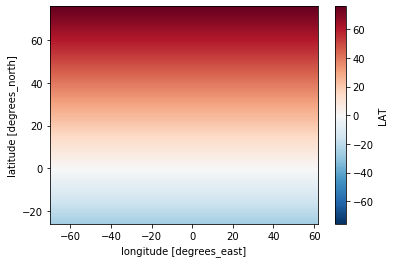

In [75]:
bg.LAT.plot()

### Create mask

In [77]:
# Create NUTS mask
# FIXME look into correct grid positioning!
nuts_mask = create_nuts_mask(gdf, bg, levels=[0,1,2,3])
# Add area array
nuts_mask = add_area(nuts_mask)
# Set chunks (change this for very large arrays!)
nuts_mask = nuts_mask.chunk({'lat':-1, 'lon':-1})
nuts_mask

-69.95
-69.95
-69.95
-69.95


<xarray.Dataset>
Dimensions:   (lat: 1019, lon: 1319)
Coordinates:
  * lat       (lat) float64 -25.95 -25.85 -25.75 -25.65 ... 75.65 75.75 75.85
  * lon       (lon) float64 -69.95 -69.85 -69.75 -69.65 ... 61.65 61.75 61.85
Data variables:
    NUTS_0    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    NUTS_1    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    NUTS_2    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    NUTS_3    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    area_km2  (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>

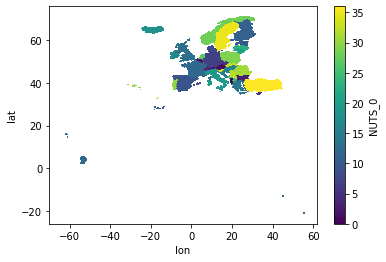

In [79]:
nuts_mask.NUTS_0.plot()

### Export to remote ZARR

In [80]:
import zarr
import xarray as xr

# Create remote ZARR
write_to_remote_zarr(nuts_mask, 'mask-array-0-1-deg', root = "copernicus-climate/ref-nuts-2016-01m.zarr")

copernicus-climate/ref-nuts-2016-01m.zarr is consoldiated? True
/
 ├── geo-data-array
 │   ├── CAPT (4, 37, 2016) object
 │   ├── CC_STAT (4, 37, 2016) object
 │   ├── CNTR_CODE (4, 37, 2016) object
 │   ├── EFTA_STAT (4, 37, 2016) object
 │   ├── EU_STAT (4, 37, 2016) object
 │   ├── ISO3_CODE (37,) object
 │   ├── LEVL_CODE (4,) int64
 │   ├── NAME_ASCI (4, 37, 2016) object
 │   ├── NAME_ENGL (4, 37, 2016) object
 │   ├── NAME_FREN (4, 37, 2016) object
 │   ├── NAME_GERM (4, 37, 2016) object
 │   ├── NAME_HTML (4, 37, 2016) object
 │   ├── NAME_LATN (4, 37, 2016) object
 │   ├── NUTS_ID (2016,) object
 │   ├── NUTS_NAME (4, 37, 2016) object
 │   ├── SVRG_UN (4, 37, 2016) object
 │   ├── Shape_Area (4, 37, 2016) float64
 │   ├── Shape_Length (4, 37, 2016) float64
 │   └── geometry (4, 37, 2016) object
 └── mask-array-0-1-deg
     ├── NUTS_0 (1019, 1319) float64
     ├── NUTS_1 (1019, 1319) float64
     ├── NUTS_2 (1019, 1319) float64
     ├── NUTS_3 (1019, 1319) float64
     ├── area_

In [0]:
#!gsutil -m rm -r "gs://copernicus-climate/ref-nuts-2016-01m.zarr"

### Get remote mask-array

In [81]:
import rioxarray
nuts_mask = get_cached_remote_zarr('mask-array-0-1-deg', root = "copernicus-climate/ref-nuts-2016-01m.zarr")\
.rio.set_spatial_dims(x_dim='lon', y_dim='lat')\
.rio.set_crs('EPSG:4326')
nuts_mask

<xarray.Dataset>
Dimensions:   (lat: 1019, lon: 1319)
Coordinates:
  * lat       (lat) float64 -25.95 -25.85 -25.75 -25.65 ... 75.65 75.75 75.85
  * lon       (lon) float64 -69.95 -69.85 -69.75 -69.65 ... 61.65 61.75 61.85
Data variables:
    NUTS_0    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    NUTS_1    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    NUTS_2    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    NUTS_3    (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>
    area_km2  (lat, lon) float64 dask.array<chunksize=(1019, 1319), meta=np.ndarray>

CPU times: user 144 ms, sys: 7.98 ms, total: 152 ms
Wall time: 482 ms


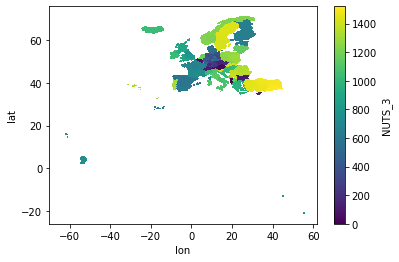

In [83]:
%%time
nuts_mask.NUTS_3.plot()